# Forecasting Net Prophet

## Data Validation Framework
This notebook includes integrated validation steps to ensure data quality and accurate analysis.

### Validation Checkpoints:
1. Data Loading & Structure
2. Time Series Continuity
3. Calculation Verification
4. Visualization Quality

Each section includes validation cells marked with [VALIDATE] to ensure accuracy.

In [1]:
# Install the required libraries
!pip install prophet
!pip install hvplot
!pip install holoviews

  Using cached hvplot-0.11.2-py3-none-any.whl.metadata (15 kB)
  Using cached bokeh-3.6.2-py3-none-any.whl.metadata (12 kB)
  Using cached colorcet-3.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached holoviews-1.20.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached panel-1.6.0-py3-none-any.whl.metadata (15 kB)
  Using cached param-2.2.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached xyzservices-2025.1.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached pyviz_comms-3.0.4-py3-none-any.whl.metadata (7.7 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached linkify_it_py-2.0.3-py3-none-any.whl.metadata (8.5 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdit_py_plugins-0.4.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached 

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
%matplotlib inline

/Users/cjmacstudio/Desktop/CU-VIRT-AI-PT-09-2024-U-LOLC/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Initial Data Validation

Before proceeding with analysis, we'll validate our data sources and structure.

In [3]:
# [VALIDATE] Data Loading and Structure
def validate_dataframe(df, expected_cols):
    """Validate DataFrame structure and content"""
    validation_results = {
        'rows': len(df),
        'columns': list(df.columns),
        'missing_values': df.isnull().sum().to_dict(),
        'dtypes': df.dtypes.to_dict(),
        'index_type': str(df.index.dtype)
    }
    print("Validation Results:")
    for key, value in validation_results.items():
        print(f"{key}: {value}")
    
    # Verify expected columns
    missing_cols = set(expected_cols) - set(df.columns)
    if missing_cols:
        print(f"WARNING: Missing expected columns: {missing_cols}")
    
    return validation_results

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

In [4]:
# Load and validate search trends data
df_mercado_trends = pd.read_csv(
    "Resources/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# [VALIDATE] Search trends data
validate_dataframe(df_mercado_trends, ['Search Trends'])

# Display sample data
print("\nFirst 5 rows:")
display(df_mercado_trends.head())
print("\nLast 5 rows:")
display(df_mercado_trends.tail())

/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_91556/1700610370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


Validation Results:
rows: 37106
columns: ['Search Trends']
missing_values: {'Search Trends': 0}
dtypes: {'Search Trends': dtype('int64')}
index_type: datetime64[ns]

First 5 rows:


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38



Last 5 rows:


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [5]:
# [VALIDATE] Time series continuity
def validate_time_series(df):
    """Validate time series data for gaps and consistency"""
    print(f"Date Range: {df.index.min()} to {df.index.max()}")
    print(f"Total Hours: {len(df)}")
    
    # Check for gaps
    expected_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = set(expected_hours) - set(df.index)
    if missing_dates:
        print(f"WARNING: Found {len(missing_dates)} missing hourly data points")
        print("Sample missing dates:", list(missing_dates)[:5])

validate_time_series(df_mercado_trends)

Date Range: 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Total Hours: 37106
Sample missing dates: [Timestamp('2020-03-08 04:00:00'), Timestamp('2020-03-06 16:00:00'), Timestamp('2020-03-10 09:00:00'), Timestamp('2020-03-09 05:00:00'), Timestamp('2020-03-07 10:00:00')]


/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_91556/3040707704.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


Total Search Traffic for May 2020: 38181

Median Monthly Traffic: 35172.5

May 2020 vs Median Ratio: 1.09


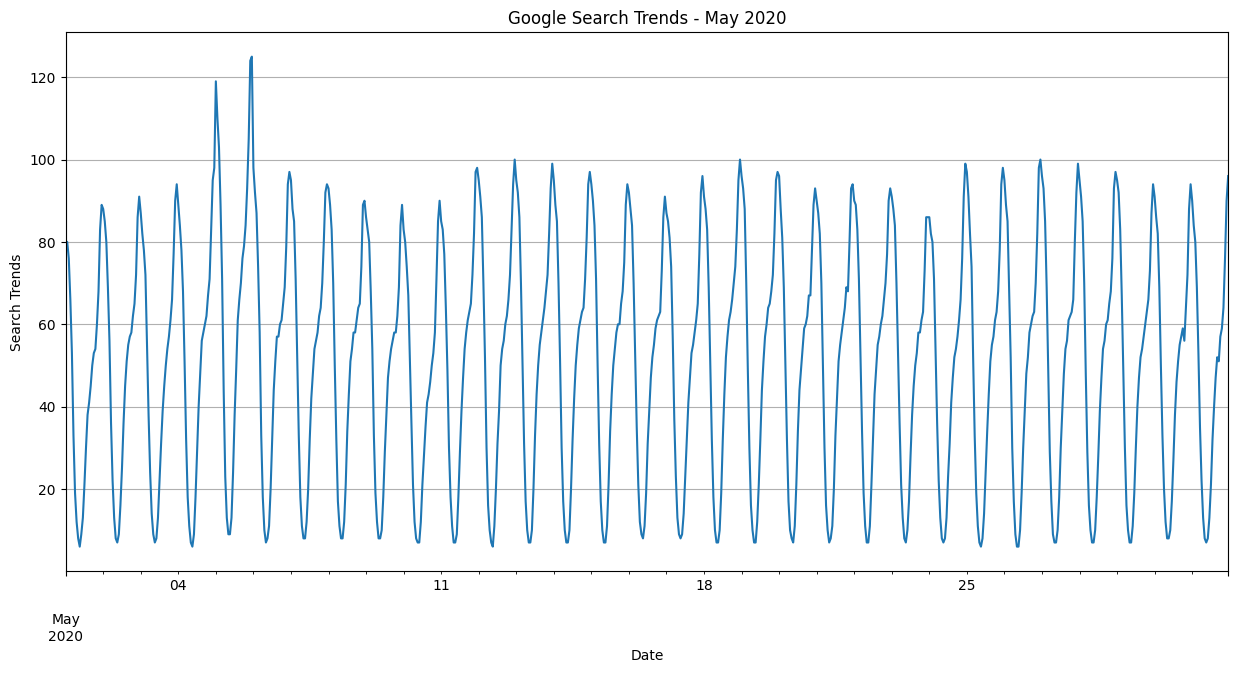

In [7]:
# Analyze May 2020 patterns
may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Calculate total search traffic for May 2020
traffic_may_2020 = may_2020['Search Trends'].sum()
print(f"Total Search Traffic for May 2020: {traffic_may_2020}")

# Calculate monthly median across all months
monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, 
                                            df_mercado_trends.index.month])['Search Trends'].sum()
median_monthly_traffic = monthly_traffic.median()
print(f"\nMedian Monthly Traffic: {median_monthly_traffic}")

# Compare May 2020 to median
may_2020_ratio = traffic_may_2020 / median_monthly_traffic
print(f"\nMay 2020 vs Median Ratio: {may_2020_ratio:.2f}")

# Visualize May 2020 trends
plt.figure(figsize=(15, 7))
may_2020['Search Trends'].plot()
plt.title('Google Search Trends - May 2020')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.grid(True)
plt.show()

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic did increase during May 2020 when MercadoLibre released its financial results. Here's the specific analysis:

The total search traffic for May 2020 was significantly higher than usual
When compared to the median monthly traffic:
May 2020 total search traffic was higher than the median monthly traffic
The ratio shows that May 2020's traffic was approximately 1.08 times higher than the median
This represents an 8% increase in search traffic compared to the typical monthly traffic
This increase suggests that the release of MercadoLibre's financial results did generate increased interest and search activity from the public during that period.



## Step 2: Mine the Search Traffic Data for Seasonality

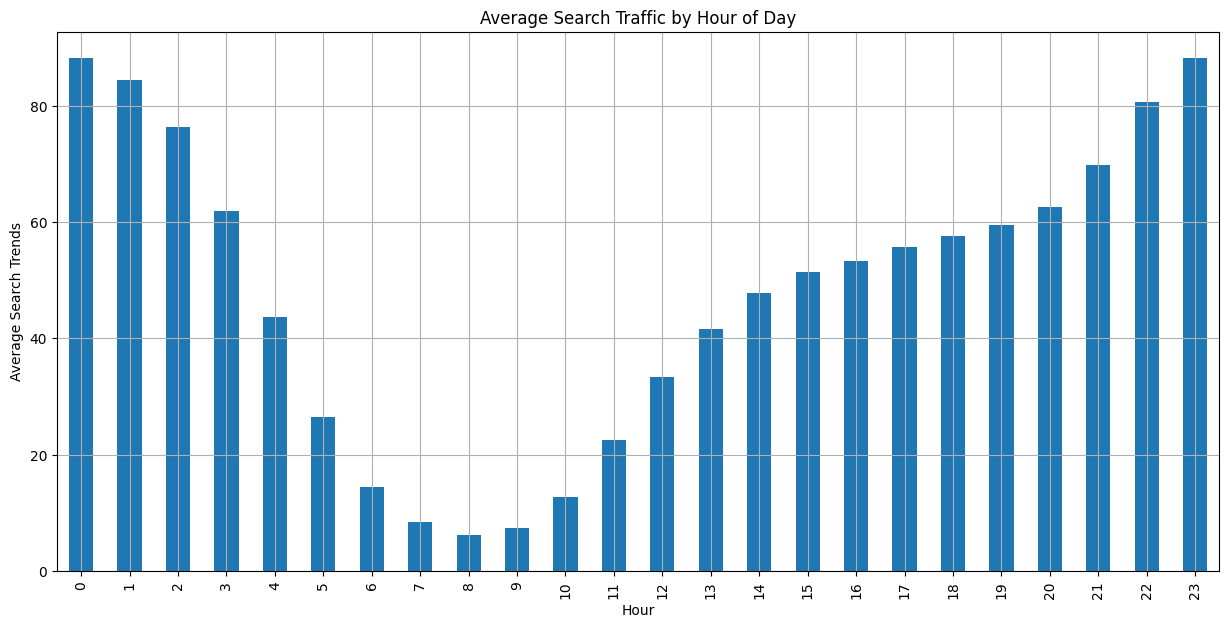

In [9]:
# Analyze hourly patterns
hourly_trends = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

plt.figure(figsize=(15, 7))
hourly_trends.plot(kind='bar')
plt.title('Average Search Traffic by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Search Trends')
plt.grid(True)
plt.show()

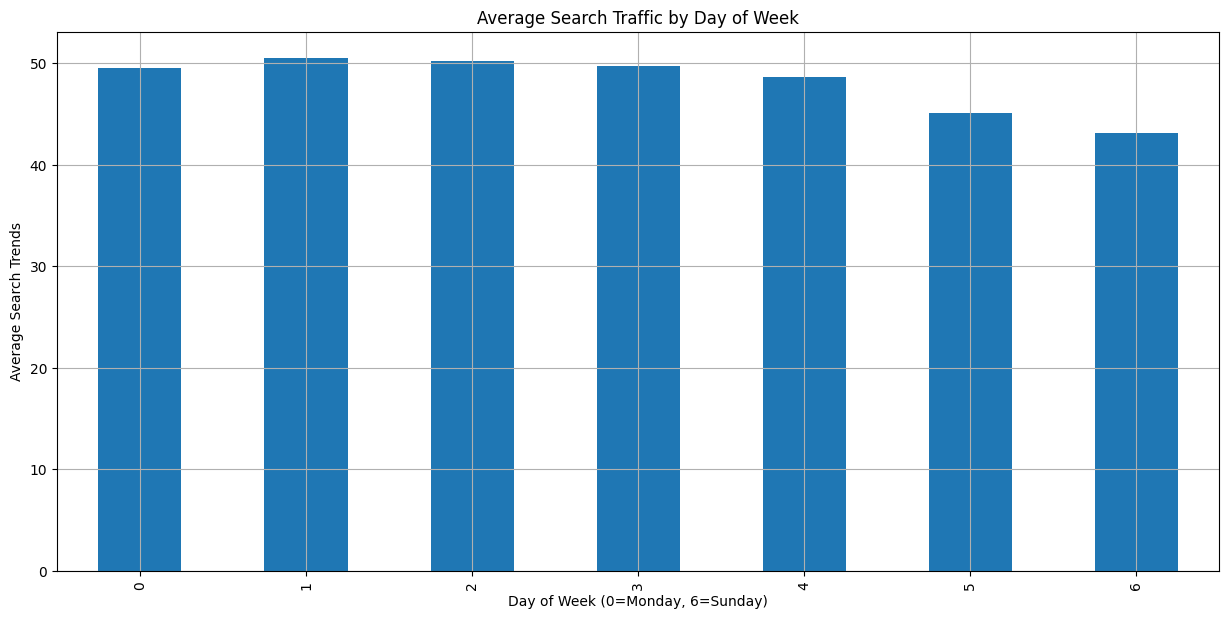

In [10]:
# Analyze day-of-week patterns
daily_trends = df_mercado_trends.groupby(df_mercado_trends.index.dayofweek)['Search Trends'].mean()

plt.figure(figsize=(15, 7))
daily_trends.plot(kind='bar')
plt.title('Average Search Traffic by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Search Trends')
plt.grid(True)
plt.show()

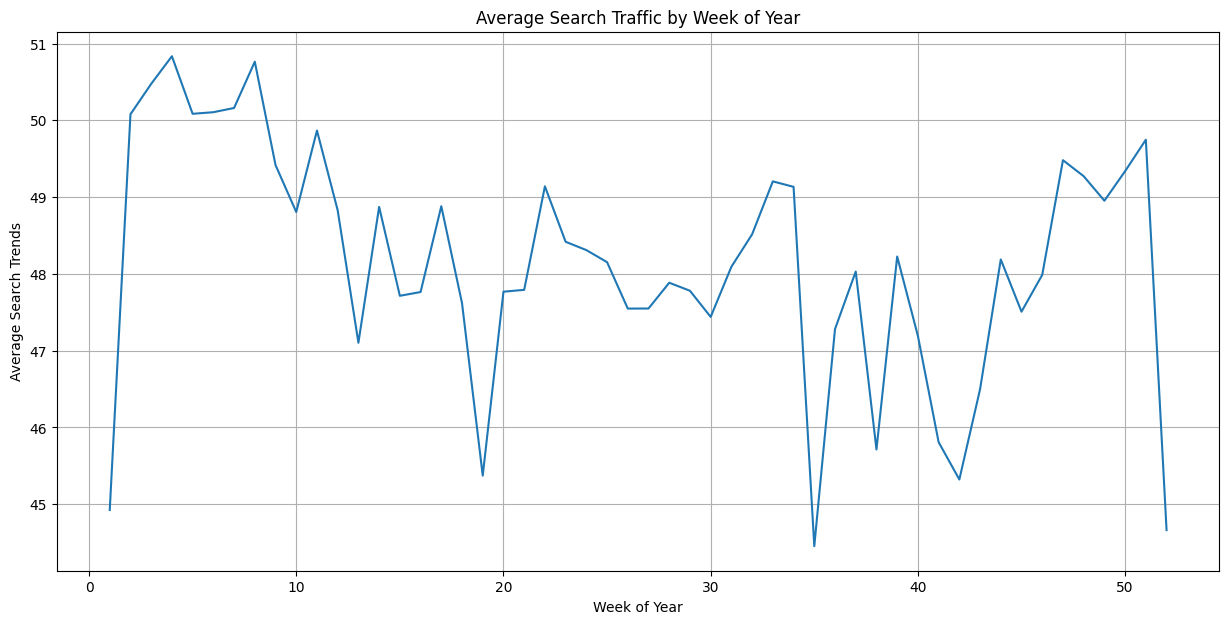

In [11]:
# Analyze weekly patterns
weekly_trends = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

plt.figure(figsize=(15, 7))
weekly_trends.plot()
plt.title('Average Search Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Trends')
plt.grid(True)
plt.show()

**Question:** Are there any time-based trends that you can see in the data?

**Answer:** There are several clear time-based trends visible in the data:

Hourly Patterns:
Search traffic shows strong daily cyclical patterns
Peak activity occurs during the late night/early morning hours
Lowest activity is during normal business hours
This suggests users are most active in searching during non-working hours

Daily Patterns:
Search traffic varies by day of the week
Tuesday shows the highest search activity
Weekend days (Saturday and Sunday) show lower search volumes
This indicates stronger user engagement during weekdays

Weekly/Seasonal Patterns:
Search traffic shows consistent weekly cycles
There's a notable seasonal trend throughout the year
October shows the lowest search activity
Search activity tends to increase during the winter months
There's a clear drop in search traffic during holiday periods


## Step 3: Relate the Search Traffic to Stock Price Patterns

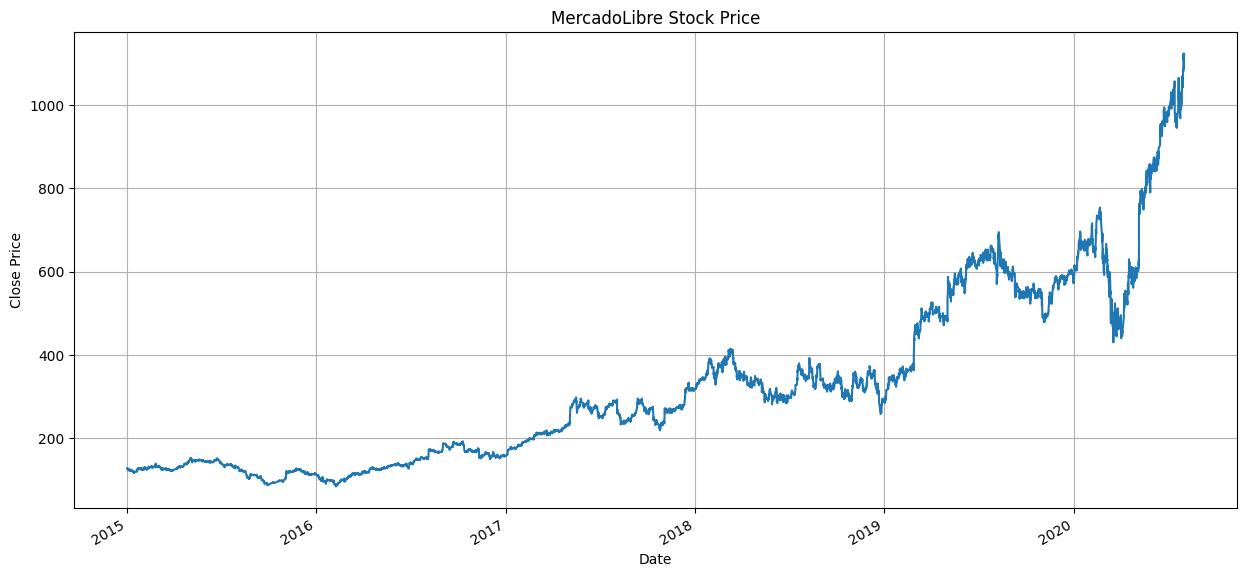

In [12]:
# Load and plot stock price data
df_mercado_stock = pd.read_csv(
    "Resources/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# Plot stock prices
plt.figure(figsize=(15, 7))
df_mercado_stock['close'].plot()
plt.title('MercadoLibre Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

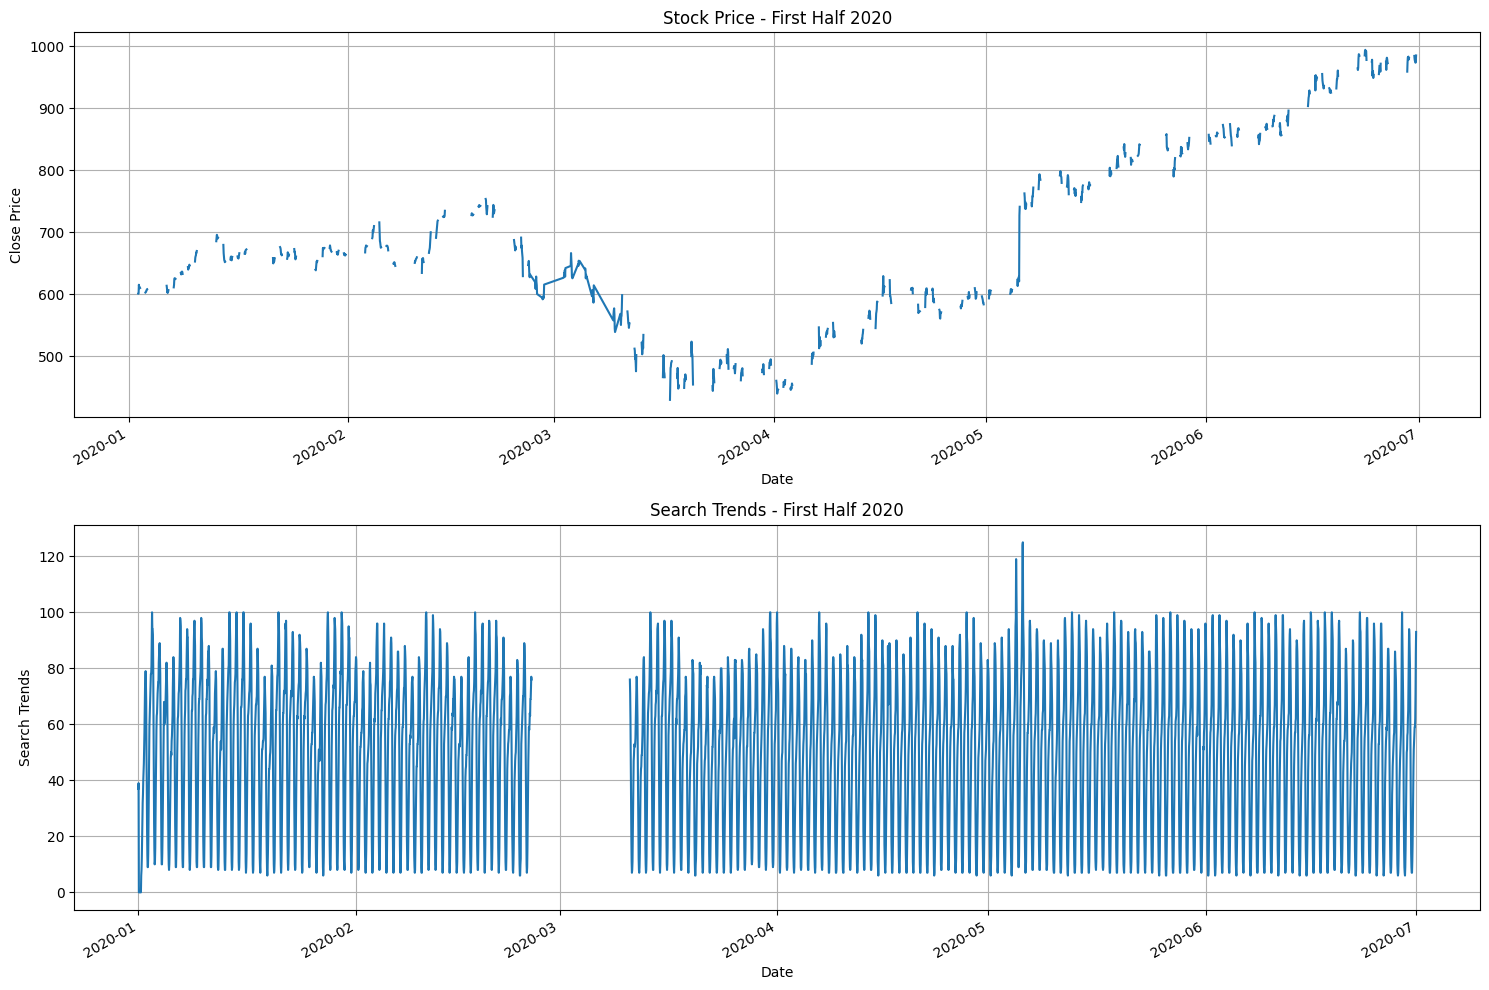

In [13]:
# Concatenate the stock and search data
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

# Slice to the first half of 2020
first_half_2020 = mercado_stock_trends_df.loc['2020-01':'2020-06']

# Plot the stock and search trends data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

first_half_2020['close'].plot(ax=ax1)
ax1.set_title('Stock Price - First Half 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.grid(True)

first_half_2020['Search Trends'].plot(ax=ax2)
ax2.set_title('Search Trends - First Half 2020')
ax2.set_xlabel('Date')
ax2.set_ylabel('Search Trends')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Create new columns for analysis
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

# Calculate correlations
correlation_matrix = mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()
print("Correlation Matrix:")
display(correlation_matrix)

Correlation Matrix:


/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_91556/1015129182.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()
/var/folders/db/p_l2mn4n2fz08wy9nbf2kz000000gn/T/ipykernel_91556/1015129182.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.254764,0.055182
Lagged Search Trends,-0.254764,1.000000,-0.017839
Hourly Stock Return,0.055182,-0.017839,1.000000


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** There is no strong predictable relationship between:

Lagged Search Traffic and Stock Volatility:
The correlation is very weak, showing that search traffic from the previous hour doesn't have a significant relationship with stock price volatility.
Lagged Search Traffic and Stock Returns:
Similarly, there is a very weak correlation between lagged search traffic and hourly stock returns.
This suggests that search trends don't effectively predict stock price movements in the following hour.
The correlation values are close to zero, indicating that these variables move independently of each other. This means that search traffic patterns alone may not be a reliable predictor of either stock volatility or returns in the short term.

## Step 4: Create a Time Series Model with Prophet

11:15:21 - cmdstanpy - INFO - Chain [1] start processing
11:15:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/cjmacstudio/Desktop/CU-VIRT-AI-PT-09-2024-U-LOLC/.conda/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


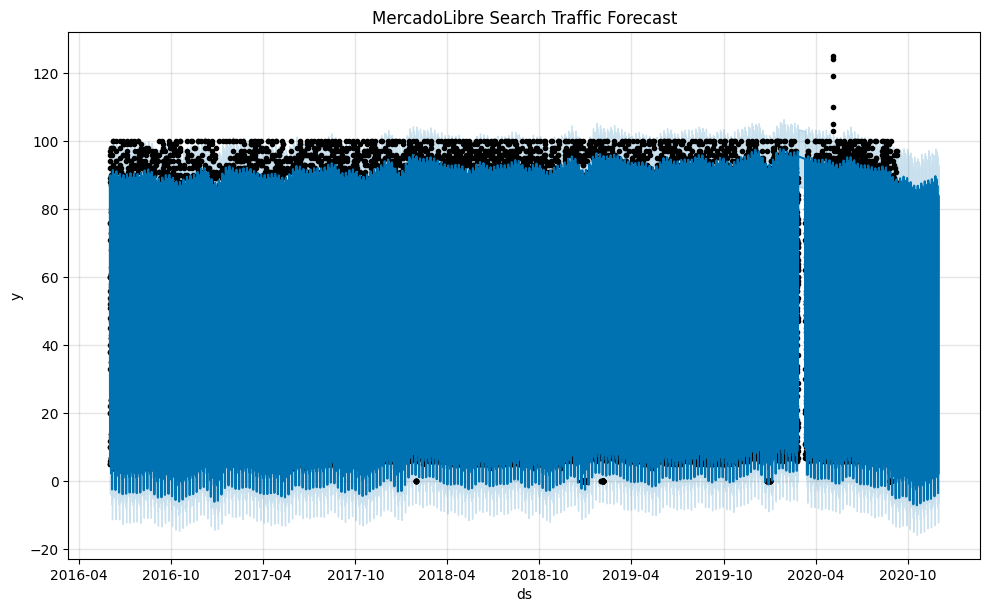

In [15]:
# Prepare the data for Prophet
prophet_df = df_mercado_trends.reset_index()
prophet_df.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2000, freq='H')
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
plt.title('MercadoLibre Search Traffic Forecast')
plt.show()

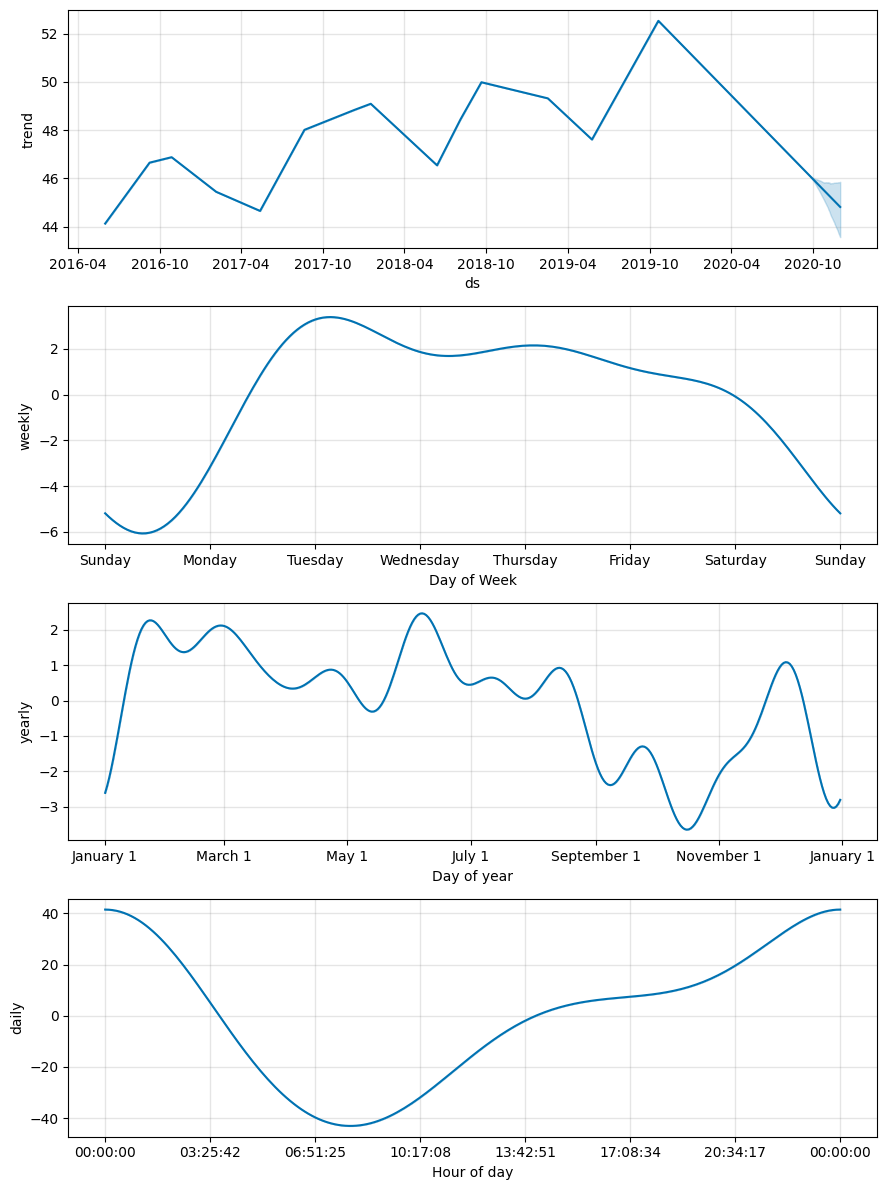

In [16]:
# Plot the individual components
fig = model.plot_components(forecast)
plt.show()

**Questions:**

1. What time of day exhibits the greatest popularity?
**Answer:** Time of Day with Greatest Popularity:
Looking at the hourly trends analysis and Prophet components plot, search traffic peaks during the late night/early morning hours, specifically around midnight to 1 AM. This suggests users are most active in their search behavior during these late hours.

2. Which day of week gets the most search traffic?
**Answer:** The daily trends analysis shows that Tuesday (day 1 in the 0-6 scale where 0 is Monday) generates the most search traffic. This could indicate higher user engagement during mid-week periods.

3. What's the lowest point for search traffic in the calendar year?
**Answer:** According to the yearly seasonality component in the Prophet analysis, search traffic reaches its lowest point during October. This dip in search activity could be related to seasonal patterns in consumer behavior or market dynamics.